# Classifying Subreddits by Title Content

### Notebook 2

This notebook picks up where the previous notebook "1-data-scraping" left off. It is a continuation of building a model to classify subreddit posts based on their title content. For a more detailed description, please refer to the first notebook.

## Table of Contents

1. [Importing Packages](#Importing-Packages)
2. [Reading Data](#Reading-Data)
3. [EDA and Cleaning](#EDA-and-Cleaning)
    1. [Initial EDA](#Initial-EDA)
    2. [Data Cleaning](#Data-Cleaning)
    3. [Additional EDA/Cleaning](#Additional-EDA/Cleaning)
        1. [Title Lengths](#Title-Lengths)
        2. [Count Vectorizing](#Count-Vectorizing)
4. [Preprocessing](#Preprocessing)
5. [Modeling](#Modeling)
    1. [Logistic Regression](#Logistic-Regression)
    2. [K-Nearest Neighbors](#K-Nearest-Neighbors)
    3. [Multinomial Naive Bayes](#Multinomial-Naive-Bayes)
    4. [Random Forest](#Random-Forest)
    5. [Boosted Decistion Tree](#Boosted-Decistion-Tree)
6. [Model Evaluations](#Model-Evaluations)
    1. [Accuracy](#Accuracy)
    2. [ROC Curve](#ROC-Curve)
7. [Conclusions and Recommendations](#Conclusions-and-Recommendations)
    1. [Conclusions](#Conclusions)
    2. [Recommendations](#Recommendations)

## Importing Packages

In [1]:
# importing basics and plotting packages
import numpy                         as np
import pandas                        as pd
import matplotlib.pyplot             as plt
import seaborn                       as sns
import regex                         as re
import graphs

# importing NLP packages
from nltk.corpus                     import stopwords
from nltk.stem                       import WordNetLemmatizer
from nltk.stem.porter                import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# importing modeling packages
from sklearn.model_selection         import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing           import StandardScaler
from sklearn.pipeline                import Pipeline
from sklearn.linear_model            import LogisticRegression
from sklearn.neighbors               import KNeighborsClassifier
from sklearn.naive_bayes             import MultinomialNB
from sklearn.tree                    import DecisionTreeClassifier
from sklearn.ensemble                import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.svm                     import SVC
from sklearn                         import metrics

# making the magic happen for plots
%matplotlib inline

# setting options for better viewing
pd.set_option("display.max_rows", 40)

## Reading Data

We want to read in the data saved from the first notebook - where the post information was pulled from reddit.

In [2]:
gaming_df = pd.read_csv("../datasets/gaming_titles.csv")
gaming_df.head()

,title,pc_sub
0,Two Lord of the Rings Inspired Mario Maker Lev...,0
1,"Request for ""offline mmo""",0
2,This sub is extremely hypocritical,0
3,Chapter 15 of Evil Within is kicking my butt//...,0
4,Turning Inferno into Dust,0


In [3]:
pcgaming_df = pd.read_csv("../datasets/pcgaming_titles.csv")
pcgaming_df.head()

,title,pc_sub
0,Crackdown 3 Flying High Update (Official Trailer),1
1,"New games coming to Gamepass. Shadow of War, D...",1
2,Super Buckyball Tournament is Coming to Steam ...,1
3,Skyrim’s murky seas finally get an overhaul un...,1
4,Nvidia RTX 2060 Super/ RTX 2070 Super Review! ...,1


Both dataframes are now loaded, but they need to be cleaned a bit before they can really be used for modeling.

## EDA and Cleaning

### Initial EDA

In [4]:
# there shouldn't be any nulls here, but never hurts to check
gaming_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1208 entries, 0 to 1207
Data columns (total 2 columns):
title     1208 non-null object
pc_sub    1208 non-null int64
dtypes: int64(1), object(1)
memory usage: 19.0+ KB


In [5]:
pcgaming_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231 entries, 0 to 1230
Data columns (total 2 columns):
title     1231 non-null object
pc_sub    1231 non-null int64
dtypes: int64(1), object(1)
memory usage: 19.4+ KB


We checked for duplicate entries within each subreddit pull in the first notebook, but did not check for possible cross-posts. We need to see if any of the posts in the r/gaming dataset show up in the r/pcgaming dataset.

In [6]:
gaming_df[gaming_df["title"].isin(pcgaming_df["title"]) == True]

,title,pc_sub
178,EVE Online players threaten to quit as devs an...,0
480,The Sinking City - Game based on H.P. Lovecraf...,0
1089,The ESA Is A Big Piece Of Shit (The Jimquisition),0
1160,SMACH Z - Tokyo Game Show 2019!,0


In [7]:
# repeating the previous cell to see them in the pcgaming df
pcgaming_df[pcgaming_df["title"].isin(gaming_df["title"]) == True]

,title,pc_sub
157,EVE Online players threaten to quit as devs an...,1
452,The Sinking City - Game based on H.P. Lovecraf...,1
1111,The ESA Is A Big Piece Of Shit (The Jimquisition),1
1190,SMACH Z - Tokyo Game Show 2019!,1


There are 4 posts that appear in both subreddits. These 4 posts will not help the model determine if a prediction should be a 0 or a 1, since it is just as likely, and removing only one post would be incorrectly telling the model that the content is from only one of the subreddits. Therefore, all eight posts need to be removed.

In [8]:
# saving the cross-posts as new dfs
gaming_cross_posts = gaming_df[gaming_df["title"].isin(pcgaming_df["title"]) == True]
pc_cross_posts = pcgaming_df[pcgaming_df["title"].isin(gaming_df["title"]) == True]

To aid us in understanding these posts and subreddits, we are also going to engineer two new columns with potentially useful information. One column will be the posts overall character length, and one column will be how many words are in the post title.

In [9]:
# adding a col of the char length of each gming post
gaming_df["char_len"] = gaming_df["title"].str.len()

# adding col of word count of each post
gaming_df["word_count"] = gaming_df["title"].apply(lambda x: len(x.split()))

# checking for the new cols
gaming_df.head()

,title,pc_sub,char_len,word_count
0,Two Lord of the Rings Inspired Mario Maker Lev...,0,73,13
1,"Request for ""offline mmo""",0,25,4
2,This sub is extremely hypocritical,0,34,5
3,Chapter 15 of Evil Within is kicking my butt//...,0,115,25
4,Turning Inferno into Dust,0,25,4


In [10]:
# duplicating for pcgaming
pcgaming_df["char_len"] = pcgaming_df["title"].str.len()

# adding col of word count of each post
pcgaming_df["word_count"] = pcgaming_df["title"].apply(lambda x: len(x.split()))

# checking for the new column
pcgaming_df.head()

,title,pc_sub,char_len,word_count
0,Crackdown 3 Flying High Update (Official Trailer),1,49,7
1,"New games coming to Gamepass. Shadow of War, D...",1,113,20
2,Super Buckyball Tournament is Coming to Steam ...,1,74,12
3,Skyrim’s murky seas finally get an overhaul un...,1,72,12
4,Nvidia RTX 2060 Super/ RTX 2070 Super Review! ...,1,74,13


In [11]:
# checking the summary stats with the new cols
gaming_df.describe()

,pc_sub,char_len,word_count
count,1208.0,1208.000000,1208.000000
mean,0.0,56.683775,10.450331
std,0.0,42.280430,8.061231
min,0.0,1.000000,1.000000
25%,0.0,29.000000,5.000000
50%,0.0,46.000000,8.000000
75%,0.0,70.000000,13.000000
max,0.0,299.000000,62.000000


In [12]:
# checking the summary stats with the new cols
pcgaming_df.describe()

,pc_sub,char_len,word_count
count,1231.0,1231.000000,1231.000000
mean,1.0,66.217709,11.402112
std,0.0,36.902681,6.533961
min,1.0,4.000000,1.000000
25%,1.0,42.000000,7.000000
50%,1.0,58.000000,10.000000
75%,1.0,81.000000,14.000000
max,1.0,299.000000,52.000000


It seems odd that the shortest character length of the gaming titles is only 1, this may need some more analysis.

In [13]:
# checking which posts have very short lengths
gaming_df[gaming_df["char_len"] <= 5]

,title,pc_sub,char_len,word_count
341,:),0,2,1
944,F,0,1,1


The smiley emoticon may not be easily parsed as a word in the modeling process, so it creates an issue. A further check will be performed to determine how many posts contain this emoticon. The second entry is just a letter "F", which is a reference to a specific video game (and a [highly ridiculed scene](https://www.gq.com/story/call-of-duty-advanced-warfare-press-to-pay-respects)), so in theory it can be useful.

In [14]:
# checking pcgaming for short posts
pcgaming_df[pcgaming_df["char_len"] <= 5]

,title,pc_sub,char_len,word_count
35,DOOM,1,4,1


The "DOOM" entry, while short, is still could be conferring some kind of meaning (DOOM is a video game) so it can be left alone for now.

In [15]:
# checking all posts with simple smiley face
gaming_df[(gaming_df["title"].str.contains(":\)"))]

,title,pc_sub,char_len,word_count
130,"Me and my boyfriends new living room, with a 1...",0,105,20
164,I drew lucario because he’s my favorite smash ...,0,61,11
222,I love the Switch for the simple fact the cont...,0,112,23
341,:),0,2,1
458,"Best bf, reliving childhood this birthday :)",0,44,7
724,I just want to give a shoutout to cube world. ...,0,143,31
912,Koffing in one of the Poznań's (Poland) pub :),0,46,9
979,"As you can see, I'm a HUGE Batman and Spider-M...",0,56,12
1016,After 3 restarted attempts and a-many F-Bombs ...,0,162,31
1080,When PUBG meets Adventure Time...a portrait :),0,46,7


There are ten post titles utilizing this smiley emoticon. In most of the titles, there is still a significant amount of language being used that confers the idea of the post, meaning that if we take away the emoticon, there is still meaning in the title. We're going to counteract this by removing punctuation later on. This will clear any emoticons from both datasets.

For the one post that is just an emoticon, it is not really giving much meaning anyway since there is no other context. Since we are also removing punctuation, that would leave a blank entry. Either way, this row can be removed.

### Data Cleaning

Since we previously identified several posts that were in both datasets, we should start off by removing those.

In [16]:
# dropping all the cross-posts
gaming_df.drop(gaming_cross_posts.index, inplace=True)
pcgaming_df.drop(pc_cross_posts.index, inplace=True)

In [17]:
# dropping the smiley entry
gaming_df.drop(index=341, inplace=True)

In [18]:
# checking the new gaming df
gaming_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1203 entries, 0 to 1207
Data columns (total 4 columns):
title         1203 non-null object
pc_sub        1203 non-null int64
char_len      1203 non-null int64
word_count    1203 non-null int64
dtypes: int64(3), object(1)
memory usage: 47.0+ KB


In [19]:
# checking the new pcgaming df
pcgaming_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1227 entries, 0 to 1230
Data columns (total 4 columns):
title         1227 non-null object
pc_sub        1227 non-null int64
char_len      1227 non-null int64
word_count    1227 non-null int64
dtypes: int64(3), object(1)
memory usage: 47.9+ KB


Now that we've removed the main problem entries, this would be a good time to "standardize" the title entries. Punctuation and non-English characters will be removed, and all the letters will be converted to lowercase.

In [20]:
# removing non-alpha chars and lowercasing words
gaming_df["title"] = gaming_df["title"].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())
pcgaming_df["title"] = pcgaming_df["title"].apply(lambda x: re.sub('[^ a-zA-Z0-9]','', x).lower())

In [21]:
# checking the new heads of the dfs
gaming_df.head()

,title,pc_sub,char_len,word_count
0,two lord of the rings inspired mario maker lev...,0,73,13
1,request for offline mmo,0,25,4
2,this sub is extremely hypocritical,0,34,5
3,chapter 15 of evil within is kicking my butt h...,0,115,25
4,turning inferno into dust,0,25,4


In [22]:
pcgaming_df.head()

,title,pc_sub,char_len,word_count
0,crackdown 3 flying high update official trailer,1,49,7
1,new games coming to gamepass shadow of war dea...,1,113,20
2,super buckyball tournament is coming to steam ...,1,74,12
3,skyrims murky seas finally get an overhaul und...,1,72,12
4,nvidia rtx 2060 super rtx 2070 super review br...,1,74,13


Now that we've removed unwanted characters, it would be a good time to make sure none of the entries were significantly changed by this process. We can reset the `char_len` column and check the summary statistics.

In [23]:
gaming_df["char_len"] = gaming_df["title"].str.len()
pcgaming_df["char_len"] = pcgaming_df["title"].str.len()

In [24]:
# making final checks
gaming_df.describe()

,pc_sub,char_len,word_count
count,1203.0,1203.000000,1203.000000
mean,0.0,54.846218,10.450540
std,0.0,41.014755,8.065756
min,0.0,1.000000,1.000000
25%,0.0,28.000000,5.000000
50%,0.0,45.000000,8.000000
75%,0.0,68.000000,13.000000
max,0.0,296.000000,62.000000


In [25]:
pcgaming_df.describe()

,pc_sub,char_len,word_count
count,1227.0,1227.000000,1227.000000
mean,1.0,64.126324,11.397718
std,0.0,35.731729,6.536253
min,1.0,4.000000,1.000000
25%,1.0,40.000000,7.000000
50%,1.0,56.000000,10.000000
75%,1.0,79.000000,14.000000
max,1.0,278.000000,52.000000


There does appear to be a slight shift down in all of the statistics, but this is to be expected - excess characters have been removed. Outside of this expected change, there have not been many significant changes.

The one value that now sticks out is the max length within pcgaming. Previously, this value was 299, but is now 278 after the cleaning. This indicates that there was a title with a large amount of non-English characters, which could be punctuation or perhaps another language.

### Additional EDA/Cleaning

While there did not initially appear to be a lot to exploration/visualization to do with this dataset, there are now a few interesting areas that are worth looking into. There is still information to be found in the data.

#### Title Lengths

In [26]:
# checking the mean title length of each subreddit
print(f"The average r/gaming post is: {gaming_df['char_len'].mean()} characters long")
print(f"The average r/pcgaming post is: {pcgaming_df['char_len'].mean()} characters long")

The average r/gaming post is: 54.84621778886118 characters long
The average r/pcgaming post is: 64.12632436837816 characters long


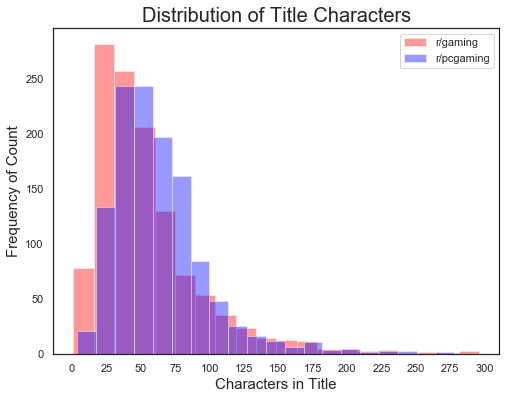

In [27]:
# making a histogram of the two post lengths
plt.figure(figsize=(8, 6))
sns.distplot(gaming_df["char_len"], kde=False, bins=20, label="r/gaming", color="red")
sns.distplot(pcgaming_df["char_len"], kde=False, bins=20, label="r/pcgaming", color="blue")
plt.title("Distribution of Title Characters", size=20)
plt.xlabel("Characters in Title", size=15)
plt.xticks(range(0, 301, 25))
plt.ylabel("Frequency of Count", size=15)
plt.legend();

It seems that posts in r/pcgaming have on average just under 10 more characters in their titles.

There is also a small, but distinct, difference in the distributions of the title lengths. They are both right-tailed, but the r/pcgaming posts have fewer short titles overall, with more titles in the 50-100 character range, shifting the distribution to the right. We can see from the purple overlapping section that there is a large amount of title lengths that are very similar between the two subreddits.

We can also compare the word counts between the subreddits with the same type of histogram.

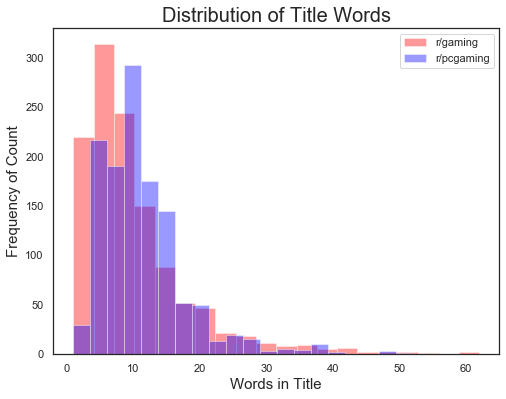

In [28]:
# checking the word length dists
plt.figure(figsize=(8, 6))
sns.distplot(gaming_df["word_count"], kde=False, bins=20, label="r/gaming", color="red")
sns.distplot(pcgaming_df["word_count"], kde=False, bins=20, label="r/pcgaming", color="blue")
plt.title("Distribution of Title Words", size=20)
plt.xlabel("Words in Title", size=15)
# plt.xticks(range(0, 61, 10))
plt.ylabel("Frequency of Count", size=15)
plt.legend();

Again there is a lot of overlap (the purple region), but the pcgaming subreddit has a shifted plot, showing a tendency to more words in the titles than the gaming subreddit. These two plots show that the word and character counts have some separability between subreddits, and may be beneficial features to have in the modeling process.

#### Count Vectorizing

We can also now look at the counts of individual words in each title or subreddit. We can use a count vectorizer to do this split and count for us, without actually doing the modeling step at this point.

Through multiple iterations of this process there were two actions identified that we want to take on our data before we perform the count vectorization: Removing stop words, and stemming the remaining words.

Even with the standard stop words removed, there were some remaining words that were coming up very frequently in both subreddits. Theses included "game", "games", and "gaming", which would be expected to be used a lot in subreddits with "gaming" in their names. As such, these were also good candidates to be considered "stop words" and were removed.

Stop words are words that are structural, but without conveying meaning (such as conjunctions). Because of this, they can be removed to get a better idea of the more significant words that appear in the titles. We started with NLTK's standard list of stop words, but that did not end up taking care of all of the highly common words. There were some remaining words that were coming up very frequently in both subreddits. Theses included "game", "games", and "gaming", which would be expected to be used a lot in subreddits with "gaming" in their names. As such, these were also good candidates to be considered "stop words" and were removed. One entry that was more interesting to see was that "PC" was not only one of the top used words in r/pcgaming, but also had a fairly high ranking in r/gaming as well.

Stemming involves bringing words down to their roots, so having multiple variations of the same word don't get counted differently. `PorterStemmer` will be used to perform this action, instead of the less extreme `WordNetLemmatizer` because it was found that the lemmatizer was not affecting certain desired words as well as the stemmer was.

In [29]:
# instantiating the stemmer
stemmer = PorterStemmer()

In [30]:
# making a list to store the standard + custom stop wrods
s_words = stopwords.words('english')

# making a list of the custom words to add
my_words = ["game", "games", "gaming", "new", "play", "get", "pc"]

# extending the standard stop words with the custom words
s_words.extend(my_words)

Now that we have our custom stop words list, we need to iterate  each of the titles and remove the correct words. This can be done by splitting up each title into its separate words, checking each word against the stop words, and keeping only the ones that do not match.

In [31]:
# removing stop words from both dfs
gaming_df["title"] = gaming_df["title"].apply(
    lambda x: " ".join([word for word in x.split() if word not in s_words])
)
pcgaming_df["title"] = pcgaming_df["title"].apply(
    lambda x: " ".join([word for word in x.split() if word not in s_words])
)

This is also a good time to stem the remaining words into their roots.

In [32]:
# repeating the lambda functions from above, but stemming the words this time
gaming_df["title"] = gaming_df["title"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in x.split()])
)
pcgaming_df["title"] = pcgaming_df["title"].apply(
    lambda x: " ".join([stemmer.stem(word) for word in x.split()])
)

In [33]:
# checking the heads of both dfs for the changes
gaming_df.head()

,title,pc_sub,char_len,word_count
0,two lord ring inspir mario maker level hope come,0,72,13
1,request offlin mmo,0,23,4
2,sub extrem hypocrit,0,34,5
3,chapter 15 evil within kick butt go second one...,0,111,25
4,turn inferno dust,0,25,4


In [34]:
pcgaming_df.head()

,title,pc_sub,char_len,word_count
0,crackdown 3 fli high updat offici trailer,1,47,7
1,come gamepass shadow war dead rise 4 undertal ...,1,108,20
2,super buckybal tournament come steam earli acc...,1,74,12
3,skyrim murki sea final overhaul underwat mod 8...,1,71,12
4,nvidia rtx 2060 super rtx 2070 super review br...,1,71,13


In [35]:
# instantiating a cvec for single words
gaming_cvec = CountVectorizer(ngram_range=(1, 1))

# fitting/transforming the gaming titles
eda_gaming_cvec = gaming_cvec.fit_transform(gaming_df["title"])

# making a dataframe of the vectors
eda_gaming_cvec_df = pd.DataFrame(eda_gaming_cvec.toarray(),
                                columns=gaming_cvec.get_feature_names())
# getting the top 10 most used words
eda_gaming_cvec_df.sum().sort_values(ascending=False).head(10)

one      51
video    44
im       44
year     43
play     42
look     39
like     39
time     38
good     38
best     35
dtype: int64

Text(0.5, 0, 'Number of Posts')

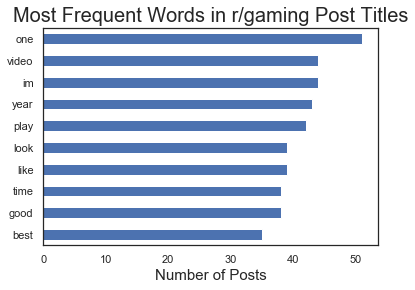

In [36]:
# plotting 
eda_gaming_cvec_df.sum().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Most Frequent Words in r/gaming Post Titles", size=20)
plt.xlabel("Number of Posts", size=15)

We can see from this plot that the most frequent word is "play", and yet it does not occur in even 10% of the total dataset of >600 post titles. Overall, these words are somewhat vague, though they still retain some gaming-related entries. "Play", "video", even "help" seem like they could be relevant to gaming-related posts. The fact that most of the posts in r/gaming seem to be jokes and memes could explain why these are the top words. "switch comes in as the 10th most used word, which is the name of Nintendo's most recent gaming console. This should definitely be a helpful word to leverage, as it is unlikely to have the same frequency in r/pcgaming.

In [37]:
# repeating the same for pcgaming...

# instantiating a cvec for single words
pcgaming_cvec = CountVectorizer(ngram_range=(1, 1))

# fitting/transforming the gaming titles
eda_pcgaming_cvec = pcgaming_cvec.fit_transform(pcgaming_df["title"])

# making a dataframe of the vectors
eda_pcgaming_cvec_df = pd.DataFrame(eda_pcgaming_cvec.toarray(),
                                columns=pcgaming_cvec.get_feature_names())
# getting the top 10 most used words
eda_pcgaming_cvec_df.sum().sort_values(ascending=False).head(10)

steam         132
trailer       116
releas         97
2019           60
free           46
come           45
epic           44
launch         41
review         39
borderland     38
dtype: int64

Text(0.5, 0, 'Number of Posts')

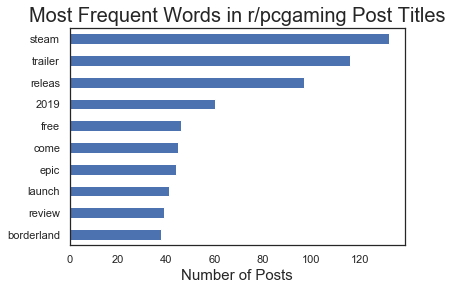

In [38]:
eda_pcgaming_cvec_df.sum().sort_values(ascending=True).tail(10).plot(kind="barh")
plt.title("Most Frequent Words in r/pcgaming Post Titles", size=20)
plt.xlabel("Number of Posts", size=15)

In r/pcgaming, the top few words are already much more specific than in r/gaming. The most frequent term, "steam", is the name of a PC-based gaming client, and is typically the subject of much discussion. Many of the remaining words seem to be centered around games that are about to come out or have recently come out - "trailer", "release", "launch", "review". Overall, this subreddit is a bit more serious in its tone, typically making posts to spread news or create discussions around issues in the gaming community.

With both of our datasets ready to go, the last step before the modeling process begins is to combine both datasets into one dataframe.

In [39]:
# concatenating the two dfs, and giving the full df a continuing index
posts_df = pd.concat([gaming_df, pcgaming_df], ignore_index=True)

In [40]:
posts_df.head()

,title,pc_sub,char_len,word_count
0,two lord ring inspir mario maker level hope come,0,72,13
1,request offlin mmo,0,23,4
2,sub extrem hypocrit,0,34,5
3,chapter 15 evil within kick butt go second one...,0,111,25
4,turn inferno dust,0,25,4


In [41]:
posts_df.tail()

,title,pc_sub,char_len,word_count
2425,deliv us moon gameplay trailer releas octob 10th,1,59,9
2426,pcgamer borderland 3 review 63100,1,34,5
2427,atom heart offici inengin cinemat trailer,1,48,6
2428,final chapter indi hit celest signal toward po...,1,84,12
2429,mistov time trial demo,1,32,6


In [42]:
posts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2430 entries, 0 to 2429
Data columns (total 4 columns):
title         2430 non-null object
pc_sub        2430 non-null int64
char_len      2430 non-null int64
word_count    2430 non-null int64
dtypes: int64(3), object(1)
memory usage: 76.1+ KB


## Preprocessing

In previous iterations of this project, vectorization was performed with the modeling, to help identify the best combination of vectorizer and algorithm . We will perform our train/test split here.

In [43]:
# setting the X and y variables
X = posts_df["title"]
y = posts_df["pc_sub"]

# performing a train/test split on the raw data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

## Modeling

This problem is a classification question, and as such we have a few options to choose from in terms of modeling. Logistic regression, K-Nearest Neighbors, Decision Trees can all be useful for predicting a specific classification based on a set of parameters.

A simple model to determine the subreddit class is as easy as picking the mode, or most frequent case. For a refresher, the split of our dataset is shown below, with 0 meaning r/gaming (the negative case), and 1 meaning r/pcgaming (the positive case).

In [44]:
posts_df["pc_sub"].value_counts(normalize=True)

1    0.504938
0    0.495062
Name: pc_sub, dtype: float64

While this base model is certainly easy to use and implement, it has room for improvement. By using the same `CountVectorizer` as above for the EDA, we can split our titles into features, and then run a logistic regression model on it. This is one of the simpler classification models, so while it may not end up being the best, it is always a good place to start.

In [45]:
# making custom gridsearching func
def pipe_searcher(pipe, params):
    gs = GridSearchCV(estimator=pipe, param_grid=params, cv=5, verbose=1, n_jobs=3)
    gs.fit(X_train, y_train)
    print(f'CrossVal Score: {gs.best_score_}')
    print(f'Training Score: {gs.score(X_train, y_train)}')
    print(f'Testing Score: {gs.score(X_test, y_test)}')
    print(gs.best_params_)
    return gs

### Logistic Regression

In [46]:
# trying a simple cvec and logreg
cvec_lr_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("logreg", LogisticRegression())
])

cvec_lr_params = {
    "cvec__max_features": [3000, 3125, 3250],
    "cvec__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "cvec__max_df": [0.1, 0.5, 0.8],
    "logreg__penalty": ["l1", "l2"]
}
# running the gridsearch on the whole thing
cvec_lr_model = pipe_searcher(cvec_lr_pipe, cvec_lr_params)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  54 tasks      | elapsed:    4.8s


CrossVal Score: 0.7777167947310648
Training Score: 0.9577387486278814
Testing Score: 0.7911184210526315
{'cvec__max_df': 0.1, 'cvec__max_features': 3125, 'cvec__ngram_range': (1, 1), 'logreg__penalty': 'l2'}


[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:   11.0s finished
/Users/jondov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


It appears that this model is very overfit. While it has a very high accuracy for the training set, it appears to have a high variance, and the testing set achieved a much lower score. One thing to try differently is the vectorizer being used.

We will switch to a TFIDF vectorizer, which differs from count vectorizer in that it uses a relative percentage of a specific term's frequency to determine if it should be removed or not.

In [47]:
# switching to tfidif
tf_lr_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("logreg", LogisticRegression())
])

tf_lr_params = {
    "tfidf__max_features": [4250, 4500, 4750],
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "tfidf__max_df": [0.1, 0.5, 0.8],
    "logreg__penalty": ["l1", "l2"]
}

# running the gridsearch on the whole thing
tf_lr_model = pipe_searcher(tf_lr_pipe, tf_lr_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.4s


CrossVal Score: 0.7886937431394072
Training Score: 0.9368825466520307
Testing Score: 0.7976973684210527
{'logreg__penalty': 'l2', 'tfidf__max_df': 0.1, 'tfidf__max_features': 4250, 'tfidf__ngram_range': (1, 1)}


[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:    8.7s finished
/Users/jondov/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Using TFIDF seems to have helped our variance a bit, by bringing down the training accuracy. However, it has also slightly decreased the testing score as well.

We will keep the better vectorizer, TFIDF, and use it on another model type, K-nearest neighbors. This model model will cluster words based on "distances" from each other from the different subreddits will have a positive impact on the scoring.

### K-Nearest Neighbors

In [48]:
# trying tfidif with knn
tf_knn_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("knn", KNeighborsClassifier())
])

tf_knn_params = {
    "tfidf__max_features": [3250, 3500, 3750],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_df": [0.05, 0.1, 0.2],
    "knn__n_neighbors": [15, 31, 45]
}

# running the gridsearch on the whole thing
tf_knn_model = pipe_searcher(tf_knn_pipe, tf_knn_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=3)]: Done  82 tasks      | elapsed:    3.4s
[Parallel(n_jobs=3)]: Done 270 out of 270 | elapsed:   14.6s finished


CrossVal Score: 0.7244785949506037
Training Score: 0.7579582875960483
Testing Score: 0.75
{'knn__n_neighbors': 31, 'tfidf__max_df': 0.1, 'tfidf__max_features': 3500, 'tfidf__ngram_range': (1, 1)}


With the KNN model, the variance has come down a lot, but so has the testing accuracy. This may be a good time to try a Naive Bayes model, which are typically good at classifying language problems, and are typically fast to model. Specifically, a multinomial naive Bayes classifier will be used, as our dataset is comprised of only positive integers.

### Multinomial Naive Bayes

In [49]:
# trying tfidif with mnb
tf_mnb_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("mnb", MultinomialNB())
])

tf_mnb_params = {
    "tfidf__max_features": [3250, 3500, 3750],
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "tfidf__max_df": [0.1, 0.5, 0.8],
    "mnb__alpha": [0.25, 0.5, 1.0, 3.0]
}

# running the gridsearch on the whole thing
tf_mnb_model = pipe_searcher(tf_mnb_pipe, tf_mnb_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 234 tasks      | elapsed:    7.2s


CrossVal Score: 0.7793633369923162
Training Score: 0.942371020856202
Testing Score: 0.7796052631578947
{'mnb__alpha': 0.5, 'tfidf__max_df': 0.1, 'tfidf__max_features': 3500, 'tfidf__ngram_range': (1, 1)}


[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed:   14.0s finished


This model puts us right back where we started, very low bias, with high variance. It is extremely overfit. Another model we could try is a decision tree classifier, although simple decision trees tend to be very overfit as well. Because of this, a more advanced model will be used. Basic decision tree models can very effective models, but tend be be very overfit, and since our models are already having a problem with this, we will jump straight to a more complex model. A random forest model can make many decision trees based on different bootstrapped datasets, and average out the predictions to counteract bias.

### Random Forest

In [50]:
# # trying tfidif with random forest
# tf_rf_pipe = Pipeline([
#     ("tfidf", TfidfVectorizer()),
#     ("rand_for", RandomForestClassifier(random_state=42))
# ])

# tf_rf_params = {
#     "tfidf__max_features": [1000, 3000, 5000],
#     "tfidf__ngram_range": [(1, 1), (1, 2)],
#     "tfidf__max_df": [0.1, 0.5],
#     "rand_for__n_estimators": [50, 100, 200],
#     "rand_for__max_depth": [100, 300, 500],
#     "rand_for__min_samples_split": [5, 25, 50],
# }

# # running the gridsearch on the whole thing
# tf_rf_model = pipe_searcher(tf_rf_pipe, tf_rf_params)

These scores are almost identical, with an even higher variance. One more model type will be tested, the `AdaBoostClassifier`, an extension of the decision trees already tried. This model will create a decision tree model, identify where it misclassified posts, and then weight those points in order to change the model in another tree. This model is therefore able to learn from previous mistakes. It will be attempted with both vectorizers, just to make sure we find the optimal conditions.

### Boosted Decistion Tree

In [51]:
# trying cvec with boosting
cvec_boost_pipe = Pipeline([
    ("cvec", CountVectorizer()),
    ("ada", AdaBoostClassifier(random_state=42))
])

cvec_boost_params = {
    "cvec__max_features": [200, 500, 1000],
    "cvec__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "cvec__max_df": [0.1, 0.5, 0.7],
#     "ada__n_estimators": [20, 100, 200] # this was hurting the variance too much
}

# running the gridsearch on the whole thing
cvec_boost_model = pipe_searcher(cvec_boost_pipe, cvec_boost_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.6s


CrossVal Score: 0.7173435784851812
Training Score: 0.7612513721185511
Testing Score: 0.7483552631578947
{'cvec__max_df': 0.1, 'cvec__max_features': 200, 'cvec__ngram_range': (1, 1)}


[Parallel(n_jobs=3)]: Done 135 out of 135 | elapsed:   10.9s finished


In [52]:
# trying tfidif with boosting
tf_boost_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("ada", AdaBoostClassifier(random_state=42))
])

tf_boost_params = {
    "tfidf__max_features": [200, 500, 1000],
    "tfidf__ngram_range": [(1, 1), (1, 2), (2, 2)],
    "tfidf__max_df": [0.1, 0.5],
#     "ada__n_estimators": [20, 100, 200] # this was hurting the variance too much
}

# running the gridsearch on the whole thing
tf_boost_model = pipe_searcher(tf_boost_pipe, tf_boost_params)

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    3.9s


CrossVal Score: 0.70801317233809
Training Score: 0.7650933040614709
Testing Score: 0.7384868421052632
{'tfidf__max_df': 0.1, 'tfidf__max_features': 200, 'tfidf__ngram_range': (1, 1)}


[Parallel(n_jobs=3)]: Done  90 out of  90 | elapsed:    7.6s finished


The boosted decision tree models are now giving us very low variance, as well as keeping the testing accuracy moderately high. A complete evaluation will be performed below, but this appears to be one of the best models.

An interesting issue was noticed when optimizing the models, especially regarding the two boosted decision tree models. When the `n_estimators` hyperparameter was left at the default option of 50, it gave some of the lowest variance scores out of all the models. However, when a list of estimator options was passed through the pipeline/gridsearch, a higher number of estimators was always picked as the best parameter. This was most likely because it made the score of the training set higher. However, this was at the cost of a very high variance when scoring the test dataset. Because of this, the list of estimator options was taken out of the modeling process.

For the remaining models, the gridsearches were re-run with and without the parameter dictionaries, but none of the other models had such a distinct difference in scores as the AdaBoost models.

### Support Vector Classifier

In [53]:
# trying tfidf with svc
tf_svc_pipe = Pipeline([
    ("tfidf", TfidfVectorizer()),
    ("svc", SVC())
])

tf_svc_params = {
    "tfidf__max_features": [5250, 5500, 5750],
    "tfidf__ngram_range": [(1, 1), (1, 2)],
    "tfidf__max_df": [0.1, 0.5, 0.7],
    "svc__C": [0.10, 0.11, 0.12],
    "svc__kernel": ["linear", "rbf"]
}

# running the gridsearch on the whole thing
tf_svc_model = pipe_searcher(tf_svc_pipe, tf_svc_params)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    4.4s
[Parallel(n_jobs=3)]: Done 194 tasks      | elapsed:   19.7s
[Parallel(n_jobs=3)]: Done 444 tasks      | elapsed:   44.3s
[Parallel(n_jobs=3)]: Done 540 out of 540 | elapsed:   54.5s finished


CrossVal Score: 0.774423710208562
Training Score: 0.8249176728869374
Testing Score: 0.7697368421052632
{'svc__C': 0.11, 'svc__kernel': 'linear', 'tfidf__max_df': 0.1, 'tfidf__max_features': 5250, 'tfidf__ngram_range': (1, 1)}


## Model Evaluations

### Accuracy

A simple model to determine the subreddit class is as easy as picking the mode, or most frequent case. For a refresher, the split of our dataset is shown below, with 0 meaning r/gaming, and 1 meaning r/pcgaming.

In [54]:
posts_df["pc_sub"].value_counts(normalize="True")

1    0.504938
0    0.495062
Name: pc_sub, dtype: float64

For this dataset, there were more posts from r/pcgaming than from r/gaming. Therefore, our base model would be to always predict r/pcgaming. However, as seen above, this would only be correct about 50% of the time. Hopefully, our complex models can do a better job than that.

To be able to easily compare all of our models, we can arrange all of the different scores into a dataframe.

Our target metric will be accuracy. In this case, it is no more detrimental to accidentally classify a post as r/gaming as it is for r/pcgaming, so sensitivity and specificity are not really important here. We only want to make sure that our predictions (either for the positive or negative class) are correct.

In [55]:
# making a df to store everything
model_df = pd.DataFrame(columns=["model", "train_acc", "test_acc", "var"])

It would be nice to iterate through one list of models multiple times to get each piece of information that we need.

In [56]:
# making a list of our models
models = [cvec_lr_model, tf_lr_model, tf_knn_model, tf_mnb_model, cvec_boost_model, tf_boost_model]

# putting each model variation into the df
model_df["model"] = [f"{model.estimator.steps[0][0]}, {model.estimator.steps[1][0]}" for model in models]

# putting in the training scores
model_df["train_acc"] = [round(model.score(X_train, y_train), 4) for model in models]

# putting in the testing scores
model_df["test_acc"] = [round(model.score(X_test, y_test), 4) for model in models]

# getting the difference, or variance, between each score
model_df["var"] = model_df["train_acc"] - model_df["test_acc"]

# checking the final dataframe
model_df

,model,train_acc,test_acc,var
0,"cvec, logreg",0.9577,0.7911,0.1666
1,"tfidf, logreg",0.9369,0.7977,0.1392
2,"tfidf, knn",0.7580,0.7500,0.0080
3,"tfidf, mnb",0.9424,0.7796,0.1628
4,"cvec, ada",0.7613,0.7484,0.0129
5,"tfidf, ada",0.7651,0.7385,0.0266


From these tables, we can see that model 0 gives us the highest overall accuracy score for the training set (lowest bias), while model 5 gives us the lowest overall variance. However, either one of these metrics is not necessarily the path to choosing the best model. The final model, which combined a TFIDF vectorizer with a boosted decision tree classifier, not only has the second lowest variance of the group, but also has the third highest test accuracy (1st being 4, and second being a tie between 0, 1, and 3).

Because of these rankings in both metrics, this model appears to give us the best balance between bias and variance. This model also has a large advantage over the base model, by having a 25% higher accuracy. With the current research, this would be the recommended model to use for classifying posts in these two subreddits.

### ROC Curve

A good way to visualize how the model performs is with an ROC curve, and calculating the AUC, or Area Under the Curve. This curve is able to show how the model makes decisions, as it plots the sensitivity, or the true positive rate, against 1-specificity, which could be classified as the false positive rate. Ideally, this curve would maintain perfect balance between the two, with the AUC being 1.0. 

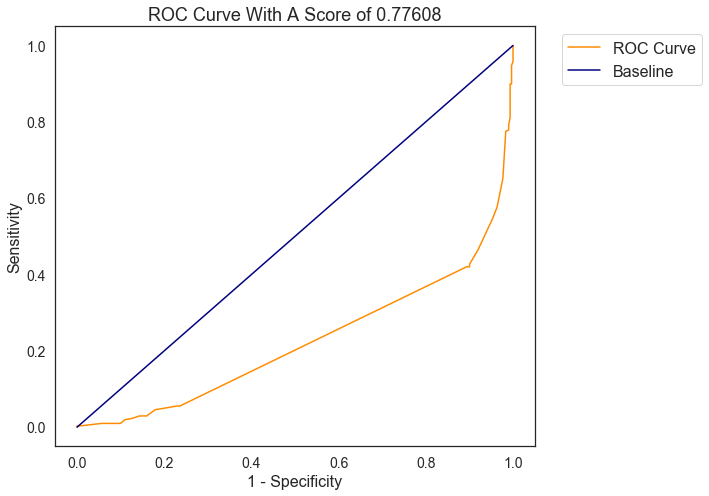

In [65]:
graphs.roc_curve(tf_boost_model, X_test, y_test, pred_proba, "ROC Curve", (10, 7), baseline_color="navy")

In [59]:
# making predictions to for the plot
pred_proba = [i[1] for i in tf_boost_model.predict_proba(X_test)]

# putting preds into a df
pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs': pred_proba})

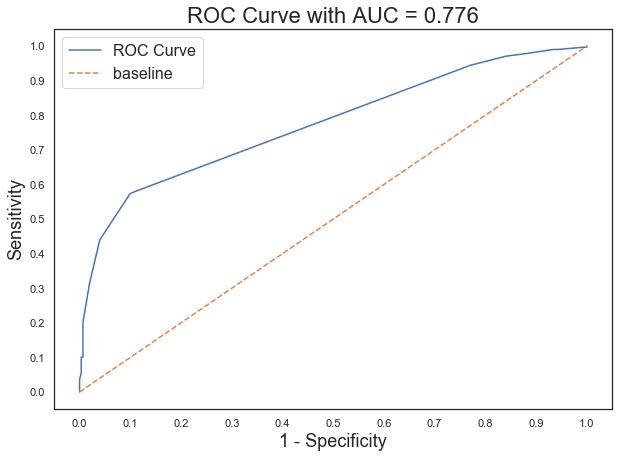

In [66]:
# adapting roc curve code from GA DSI lesson 4.04 (Matthew Brems)
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values. (Dashed red line in image.)
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    
# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title(f'ROC Curve with AUC = {round(metrics.roc_auc_score(pred_df["true_values"], pred_df["pred_probs"]),3)}', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.yticks(np.arange(0.0, 1.1, 0.1))
plt.xlabel('1 - Specificity', fontsize=18)
plt.xticks(np.arange(0.0, 1.1, 0.1))

# Create legend.
plt.legend(fontsize=16);

This ROC plot shows that that is initially a high amount of sensitivity in the model, but then around 0.1 of the x-axis, there is a sharp drop and there is a consistent relationship between the two up until around 0.85 on the a-axis. The exact meaning behind this large flat portion of the curve is not known at this time.

Using this curve, the ideal probability point for the model to make a pcgaming classification would be at that sharp corner. We did not attempt to determine the probability value of that point in this project.

## Conclusions and Recommendations

### Conclusions

This project has proven that natural language processing is a difficult tool to effectively wield. It is highly important to have a knowledge of the text that is being processed in order to have the most effective results, and it can be difficult to determine when and how certain steps need to be taken.

In the end, we were able to create a fairly effective boosted decision tree model to classify subreddit posts between the two target subreddits, r/gaming and r/pcgaming. At above 78% accurate, it is a significant step up from a coin flip or the base model, though it is still far from perfect. A decision to use a model of this performance to classify these subreddits (or another pair of classifications) greatly depends on the risk involved in those classifications. For this project, the stakes seem quite low, but in other situations a 78.4% accuracy may be completely unacceptable.

It is unfortunate that this model type leaves almost no transparency in which words were or were not important in making the classification. 

It also important to note that this model will only be effective when classifying posts between these two specific subreddits. The model is built on the specific words that are used in these subreddits, and other subreddits will most likely have many differences in the words that are used, and how they are being used.

The words being used even within these two subreddits is likely to evolve over time, especially when important events happen in the gaming industry, so the effectiveness of this model may not last a long time. The data that this model was built on was pulled from a specific period of time, on or around July 9, 2019.

### Recommendations

It does appear that there may be some further optimization to be done with this model. Also with our testing score still being below 80%, it would be helpful to build something a bit more accurate, possibly by fitting another type of model, such as a support vector machine. 

With the issue that was found regarding the `n_estimators` hyperparameter in the boosted models, we see an opportunity to perform and even deeper dive into the hyperparameters that were used, and even those that had not been changed here. There may be a model that has similar or better performance to our final selected model, when a very specific combination of parameters are used, which may not be immediately noticeable when using a typical gridsearch. There is also a wealth of additional information on each of the posts from the initial pull. While we isolate the title from each post, in the original datasets there was additional information such as `selftext`, number of comments, and more. These could all prove to be useful pieces of information for this classification problem.

Additionally, in order to keep the model as accurate as possible, new data should be pulled periodically to add to the dataset, so as to account for changing trends in post language.